In [1]:
import os
import warnings
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import transformers
transformers.logging.set_verbosity_error()  

/Users/sumedh/Library/Mobile Documents/com~apple~CloudDocs/Development/slang_detection/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Setup
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True)
model.eval()
print("Bert Model Loaded")

Bert Model Loaded


In [3]:
# get a sentance as a list of words
target_word = "frisk"
word_list= ['my', 'new', 'most', 'wanted', 'character', 'in', 'smash', 'is', 'frisk', 'undertale']
target_idx = word_list.index(target_word)
print(f"Input Sentence: {word_list}")
print(f"Number of words in Sentence: {len(word_list)}")
print()

Input Sentence: ['my', 'new', 'most', 'wanted', 'character', 'in', 'smash', 'is', 'frisk', 'undertale']
Number of words in Sentence: 10



In [4]:
#tokenize the words
tokens = tokenizer(word_list, is_split_into_words=True, return_tensors="pt")
print(f"Tokenized Input: {tokens['input_ids'].tolist()}")
print(f"Size of Tokenized Input: {tokens['input_ids'].shape}")
print()

Tokenized Input: [[101, 2026, 2047, 2087, 2359, 2839, 1999, 15132, 2003, 10424, 20573, 2104, 22059, 102]]
Size of Tokenized Input: torch.Size([1, 14])



In [17]:
# run forward pass
with torch.no_grad():
    outputs = model(**tokens)

In [19]:
# get the last hidden state
last_hidden_layer = outputs.hidden_states[-1]
print(f"Last Hidden State Shape: {last_hidden_layer.shape}") 
print()

Last Hidden State Shape: torch.Size([1, 14, 768])



In [20]:
# NOTE: The same word may appear twice in the sentence-->use the occurrence given in the problem instance
# NOTE: A single word may be split into multiple tokens-->
        # DESCISION 1: Take the mean of the embeddings of the tokens
        # Alternates: Take first/min/max
        # Ideas: Try some sort of "custom weighting"
        # Try to do a weighted avg by using the attention weights?


# NOTE: Strategy: lookup which tokens belong to target_idx & take the mean of the embeddings of the tokens
print(f"for each token, which word did I come from?")
token_to_word_idx = tokens.word_ids()
print(f"token_indices: {token_to_word_idx}")

for each token, which word did I come from?
token_indices: [None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 9, None]


In [21]:
token_indices = [i for i, w in enumerate(token_to_word_idx) if w == target_idx]
print(f"Token Indices: {token_indices}")
embeddings = last_hidden_layer[0]
word_embeddings = embeddings[token_indices]
print(f"Word Embedding(s) Shape: {word_embeddings.shape}")
mean_embedding = word_embeddings.mean(dim=0)
print(f"Mean Embedding Shape: {mean_embedding.shape}")

Token Indices: [9, 10]
Word Embedding(s) Shape: torch.Size([2, 768])
Mean Embedding Shape: torch.Size([768])


In [ ]:
# get the mean of embedding vectors for the word at word_idx in sentance word_list
def get_embedding(word_list, target_idx, layer_idx):
    tokens = tokenizer(word_list, is_split_into_words=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    embeddings = outputs.hidden_states[layer_idx][0]
    token_indices = [i for i, w in enumerate(tokens.word_ids()) if w == target_idx]
    word_embeddings = embeddings[token_indices]
    return word_embeddings.mean(dim=0)

def compute_similarity(embedding_1, embedding_2):
    return torch.nn.functional.cosine_similarity(embedding_1, embedding_2, dim=0)


'''
For each problem instance:
    for every layer in the model
        get the emebdding of the 
'''

# Simple Test of Cosine Similarity between words in two sentances
# DECISION: What should I use as Cosine Similarity Metric?
from data_loader import *
instance = next(data_iterator("TRAIN"))
embedding_1 = get_embedding(instance.tweet1.tokens, instance.tweet1.word_idx, -1)
embedding_2 = get_embedding(instance.tweet2.tokens, instance.tweet2.word_idx, -1)
similarity = compute_similarity(embedding_1, embedding_2)
print(similarity)


'''
Plots:
    (vec1, vec2, sim)
'''



tensor(0.6743)


Processing TRAIN data: 100%|██████████| 1428/1428 [01:29<00:00, 15.95it/s]


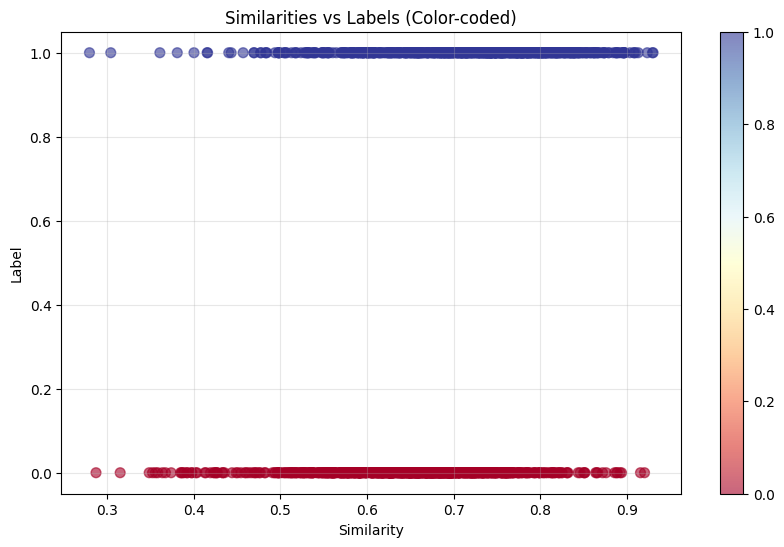

'\nsimilaruty vs label\n'

In [30]:
from data_loader import *
from tqdm import tqdm
import numpy as np

def collect_similarities_and_labels(path, layer_idx=-1):
    sims, labels = [], []

    # Get an iterator and wrap it with tqdm for progress display
    iterator = data_iterator(path)
    total = sum(1 for _ in open(TRAIN_PATH if path == "TRAIN" else VAL_PATH))  # optional: estimate total
    iterator = tqdm(iterator, total=total, desc=f"Processing {path} data")

    for instance in iterator:
        try:
            e1 = get_embedding(instance.tweet1.tokens, instance.tweet1.token_idx, layer_idx)
            e2 = get_embedding(instance.tweet2.tokens, instance.tweet2.token_idx, layer_idx)
            sim = compute_similarity(e1, e2).item()
            sims.append(sim)
            labels.append(instance.y)
        except Exception as e:
            iterator.write(f"Skipping instance {getattr(instance, 'id', '?')}: {e}")
            continue

    iterator.close()
    return np.array(sims), np.array(labels)

sims, labels = collect_similarities_and_labels("TRAIN", -1)


plt.figure(figsize=(10, 6))
plt.scatter(sims, labels, c=labels, cmap='RdYlBu', alpha=0.6, s=50)
plt.xlabel('Similarity')
plt.ylabel('Label')
plt.title('Similarities vs Labels (Color-coded)')
plt.colorbar()
plt.grid(True, alpha=0.3)
plt.show()

'''
similaruty vs label
'''


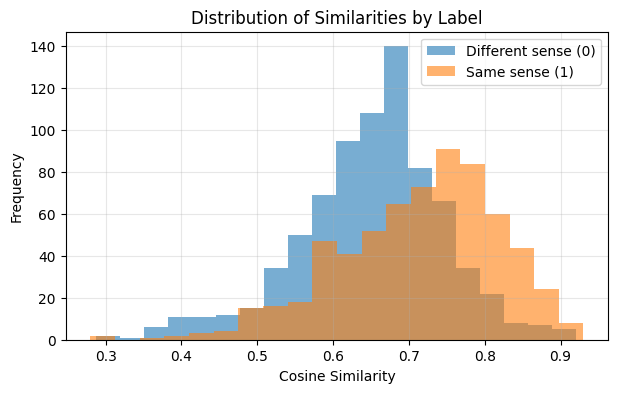

In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,4))
plt.hist(sims[labels==0], bins=20, alpha=0.6, label='Different sense (0)')
plt.hist(sims[labels==1], bins=20, alpha=0.6, label='Same sense (1)')
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Similarities by Label")
plt.legend()
plt.grid(alpha=0.3)
plt.show()




In [ ]:
# for a given problem instance, cache embeddings for each layer

def get_hidden_layers(word_list, word_idx):
    tokens = tokenizer(word_list, is_split_into_words=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.hidden_states

for instance in data_iterator("TRAIN"):
    get_hidden_layers(instance.tweet1.tokens, instance.tweet1.word_idx)
    get_hidden_layers(instance.tweet2.tokens, instance.tweet2.word_idx)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Creating visualization features...


Creating visualization features from TRAIN: 100%|██████████| 1428/1428 [01:25<00:00, 16.67it/s]


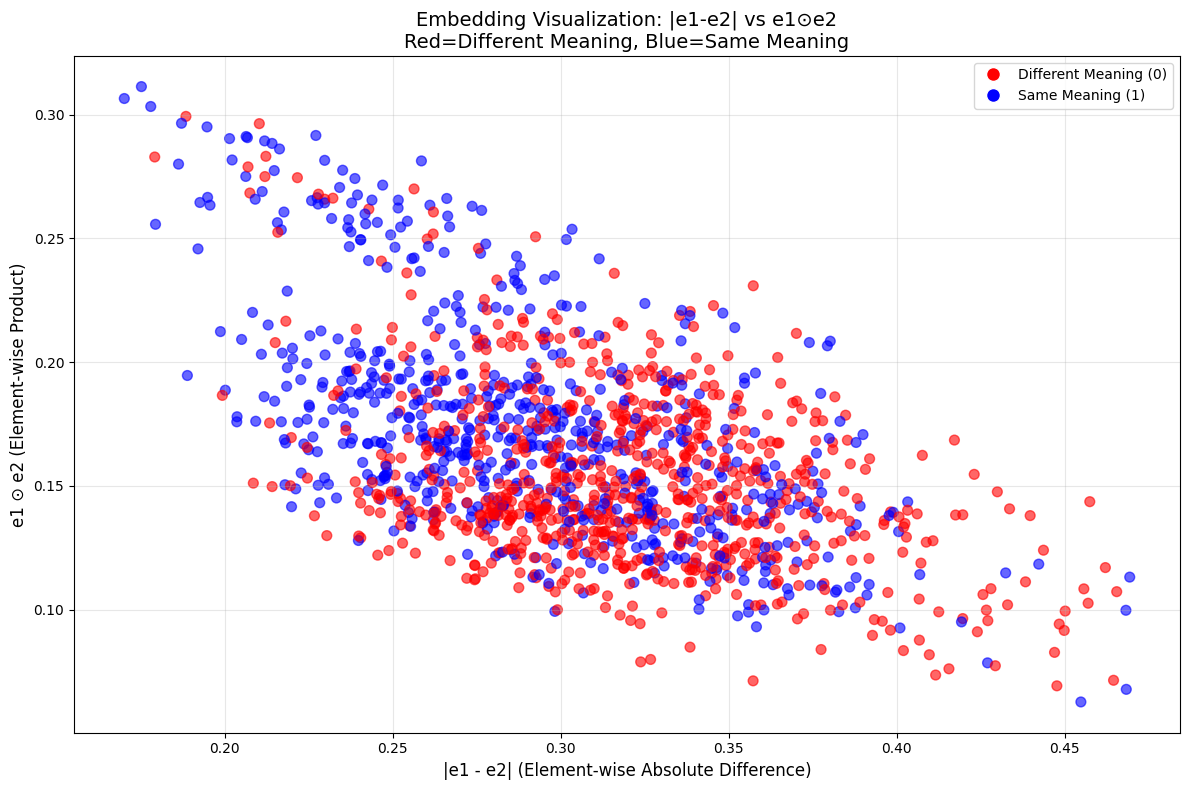


Visualization Statistics:
Total points: 1428
Red points (Different): 778
Blue points (Same): 650
X-coord range: [0.1702, 0.4694]
Y-coord range: [0.0627, 0.3113]


In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Extract embeddings and create the visualization features
def create_embedding_visualization_features(path, layer_idx=-1):
    """
    Extract embeddings and create visualization features:
    - X: |e1 - e2| (element-wise absolute difference)
    - Y: e1 ⊙ e2 (element-wise product)
    """
    x_coords = []  # |e1 - e2|
    y_coords = []  # e1 ⊙ e2
    labels = []
    
    iterator = data_iterator(path)
    total = sum(1 for _ in open(TRAIN_PATH if path == "TRAIN" else VAL_PATH))
    iterator = tqdm(iterator, total=total, desc=f"Creating visualization features from {path}")
    
    for instance in iterator:
        try:
            # Get embeddings for both tweets
            e1 = get_embedding(instance.tweet1.tokens, instance.tweet1.token_idx, layer_idx)
            e2 = get_embedding(instance.tweet2.tokens, instance.tweet2.token_idx, layer_idx)
            
            # Convert to numpy
            e1_np = e1.cpu().numpy()
            e2_np = e2.cpu().numpy()
            
            # Create visualization features
            # X-coordinate: element-wise absolute difference
            abs_diff = np.abs(e1_np - e2_np)
            x_coord = np.mean(abs_diff)  # Take mean to get single value
            
            # Y-coordinate: element-wise product
            element_wise_prod = e1_np * e2_np
            y_coord = np.mean(element_wise_prod)  # Take mean to get single value
            
            x_coords.append(x_coord)
            y_coords.append(y_coord)
            labels.append(instance.y)
            
        except Exception as e:
            iterator.write(f"Skipping instance {getattr(instance, 'id', '?')}: {e}")
            continue
    
    iterator.close()
    return np.array(x_coords), np.array(y_coords), np.array(labels)

# Create features for visualization
print("Creating visualization features...")
x_coords, y_coords, viz_labels = create_embedding_visualization_features("TRAIN", layer_idx=-1)

# Create the scatter plot
plt.figure(figsize=(12, 8))

# Plot with different colors for different labels
# Red for label 0 (different meaning), Blue for label 1 (same meaning)
colors = ['red' if label == 0 else 'blue' for label in viz_labels]

plt.scatter(x_coords, y_coords, c=colors, alpha=0.6, s=50)

plt.xlabel('|e1 - e2| (Element-wise Absolute Difference)', fontsize=12)
plt.ylabel('e1 ⊙ e2 (Element-wise Product)', fontsize=12)
plt.title('Embedding Visualization: |e1-e2| vs e1⊙e2\nRed=Different Meaning, Blue=Same Meaning', fontsize=14)

# Add legend
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Different Meaning (0)')
blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Same Meaning (1)')
plt.legend(handles=[red_patch, blue_patch])

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nVisualization Statistics:")
print(f"Total points: {len(x_coords)}")
print(f"Red points (Different): {(viz_labels == 0).sum()}")
print(f"Blue points (Same): {(viz_labels == 1).sum()}")
print(f"X-coord range: [{x_coords.min():.4f}, {x_coords.max():.4f}]")
print(f"Y-coord range: [{y_coords.min():.4f}, {y_coords.max():.4f}]")

## Train a Classifier on Embeddings

Now let's extract embedding pairs and train a classifier to predict whether two word instances have the same meaning.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
import numpy as np

def extract_embedding_features(path, layer_idx=-1):
    """
    Extract embedding pairs and labels for classification.
    Returns concatenated embeddings and element-wise differences.
    """
    features = []
    labels = []
    
    iterator = data_iterator(path)
    total = sum(1 for _ in open(TRAIN_PATH if path == "TRAIN" else VAL_PATH))
    iterator = tqdm(iterator, total=total, desc=f"Extracting features from {path}")
    
    for instance in iterator:
        try:
            # Get embeddings for both tweets
            e1 = get_embedding(instance.tweet1.tokens, instance.tweet1.token_idx, layer_idx)
            e2 = get_embedding(instance.tweet2.tokens, instance.tweet2.token_idx, layer_idx)
            
            # Create feature vector: concatenate embeddings and their difference
            # This gives the model more information about the relationship
            e1_np = e1.cpu().numpy()
            e2_np = e2.cpu().numpy()
            
            # Option 1: Just concatenate the two embeddings
            feature_vec = np.concatenate([e1_np, e2_np])
            
            # Option 2: Add element-wise operations (uncomment to try)
            # diff = e1_np - e2_np
            # prod = e1_np * e2_np
            # feature_vec = np.concatenate([e1_np, e2_np, diff, prod])
            
            features.append(feature_vec)
            labels.append(instance.y)
        except Exception as e:
            iterator.write(f"Skipping instance {getattr(instance, 'id', '?')}: {e}")
            continue
    
    iterator.close()
    return np.array(features), np.array(labels)

print("Extracting features from training data...")
X_train, y_train = extract_embedding_features("TRAIN", layer_idx=-1)
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")


Extracting features from training data...


Extracting features from TRAIN:  20%|██        | 288/1428 [00:15<00:59, 19.07it/s]

In [19]:
print("Extracting features from validation data...")
X_val, y_val = extract_embedding_features("VAL", layer_idx=-1)
print(f"Validation set: {X_val.shape[0]} samples, {X_val.shape[1]} features")

print(f"\nLabel distribution:")
print(f"Train - Same meaning (1): {(y_train == 1).sum()}, Different meaning (0): {(y_train == 0).sum()}")
print(f"Val - Same meaning (1): {(y_val == 1).sum()}, Different meaning (0): {(y_val == 0).sum()}")


Extracting features from validation data...


Extracting features from VAL: 100%|██████████| 396/396 [00:26<00:00, 15.03it/s]

Validation set: 396 samples, 1536 features

Label distribution:
Train - Same meaning (1): 650, Different meaning (0): 778
Val - Same meaning (1): 172, Different meaning (0): 224


In [34]:
# Train a Logistic Regression classifier
print("Training Logistic Regression classifier...")
clf = LogisticRegression(max_iter=1000, random_state=42, verbose=1)
clf.fit(X_train, y_train)
print("Training complete!")


Training Logistic Regression classifier...


NameError: name 'LogisticRegression' is not defined

In [ ]:
# Evaluate on training set
y_train_pred = clf.predict(X_train)
y_train_proba = clf.predict_proba(X_train)[:, 1]

train_auc = roc_auc_score(y_train, y_train_proba)
train_f1 = f1_score(y_train, y_train_pred)

print("="*60)
print("TRAINING SET RESULTS")
print("="*60)
print(f"AUC: {train_auc:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_train, y_train_pred, target_names=['Different', 'Same']))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))


In [22]:
# Evaluate on validation set
y_val_pred = clf.predict(X_val)
y_val_proba = clf.predict_proba(X_val)[:, 1]

val_auc = roc_auc_score(y_val, y_val_proba)
val_f1 = f1_score(y_val, y_val_pred)

print("="*60)
print("VALIDATION SET RESULTS")
print("="*60)
print(f"AUC: {val_auc:.4f}")
print(f"F1 Score: {val_f1:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Different', 'Same']))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

print("\n" + "="*60)
print(f"COMPARISON: Cosine Similarity vs Classifier")
print("="*60)
print(f"Cosine Similarity Baseline: AUC = {roc_auc_score(labels, sims):.4f}")
print(f"Logistic Regression:        AUC = {train_auc:.4f} (train), {val_auc:.4f} (val)")


VALIDATION SET RESULTS
AUC: 0.6121
F1 Score: 0.4380

Classification Report:
              precision    recall  f1-score   support

   Different       0.62      0.81      0.70       224
        Same       0.59      0.35      0.44       172

    accuracy                           0.61       396
   macro avg       0.60      0.58      0.57       396
weighted avg       0.61      0.61      0.59       396


Confusion Matrix:
[[182  42]
 [112  60]]

COMPARISON: Cosine Similarity vs Classifier
Cosine Similarity Baseline: AUC = 0.6830
Logistic Regression:        AUC = 1.0000 (train), 0.6121 (val)


/Users/sumedh/Library/Mobile Documents/com~apple~CloudDocs/Development/slang_detection/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sumedh/Library/Mobile Documents/com~apple~CloudDocs/Development/slang_detection/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sumedh/Library/Mobile Documents/com~apple~CloudDocs/Development/slang_detection/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sumedh/Library/Mobile Documents/com~apple~CloudDocs/Development/slang_detection/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sumedh/Library/Mobile Documents/com~apple~CloudDocs/Development/slang_detection/.venv/lib/python3.9/site-packages/sklearn/utils/

## Experiment with Different Layers (Optional)

You can try extracting embeddings from different BERT layers to see which performs best.


## Comparing Different Classifiers and Hyperparameter Tuning

Let's compare multiple classifiers and tune their hyperparameters to find the best model.


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import time

# Standardize features (important for neural networks and SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Features standardized (mean=0, std=1)")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Validation set shape: {X_val_scaled.shape}")


Features standardized (mean=0, std=1)
Training set shape: (1428, 1536)
Validation set shape: (396, 1536)


In [27]:
# Define classifiers with different hyperparameters to try
classifiers = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength (smaller = more regularization)
            'penalty': ['l2'],  # Type of regularization
            'solver': ['lbfgs']
        }
    },
    
    'Neural Network (MLP)': {
        'model': MLPClassifier(max_iter=1000, random_state=42, early_stopping=True),
        'params': {
            'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64)],  # Network architecture
            'alpha': [0.0001, 0.001, 0.01],  # L2 regularization
            'learning_rate_init': [0.001, 0.01]  # Initial learning rate
        }
    },
    
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],  # Number of trees
            'max_depth': [10, 20, None],  # Maximum depth of trees
            'min_samples_split': [2, 5, 10]  # Minimum samples to split
        }
    },
    
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],  # Number of boosting stages
            'learning_rate': [0.01, 0.1, 0.5],  # Shrinks contribution of each tree
            'max_depth': [3, 5, 7]  # Maximum depth of trees
        }
    },
    
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],  # Regularization parameter
            'kernel': ['rbf', 'linear'],  # Kernel type
            'gamma': ['scale', 'auto']  # Kernel coefficient
        }
    }
}

print("Classifiers defined:")
for name in classifiers.keys():
    print(f"  - {name}")
print(f"\nReady to train and compare!")


Classifiers defined:
  - Logistic Regression
  - Neural Network (MLP)
  - Random Forest
  - Gradient Boosting
  - SVM

Ready to train and compare!


In [28]:
# Train and evaluate each classifier with hyperparameter tuning
results = []

for name, config in classifiers.items():
    print(f"\n{'='*70}")
    print(f"Training: {name}")
    print(f"{'='*70}")
    
    start_time = time.time()
    
    # Grid Search with Cross-Validation
    # This tries all parameter combinations and finds the best one
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=3,  # 3-fold cross-validation
        scoring='roc_auc',  # Optimize for AUC
        n_jobs=-1,  # Use all CPU cores
        verbose=1
    )
    
    # Fit on training data
    grid_search.fit(X_train_scaled, y_train)
    
    training_time = time.time() - start_time
    
    # Best model found
    best_model = grid_search.best_estimator_
    
    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val_scaled)
    y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]
    
    val_auc = roc_auc_score(y_val, y_val_proba)
    val_f1 = f1_score(y_val, y_val_pred)
    
    # Store results
    results.append({
        'name': name,
        'best_params': grid_search.best_params_,
        'cv_auc': grid_search.best_score_,  # Cross-validation AUC on training set
        'val_auc': val_auc,
        'val_f1': val_f1,
        'training_time': training_time,
        'model': best_model
    })
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Cross-val AUC (train): {grid_search.best_score_:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")
    print(f"Validation F1: {val_f1:.4f}")
    print(f"Training time: {training_time:.2f} seconds")

print(f"\n{'='*70}")
print("All models trained!")
print(f"{'='*70}")



Training: Logistic Regression
Fitting 3 folds for each of 5 candidates, totalling 15 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Cross-val AUC (train): 0.4355
Validation AUC: 0.6159
Validation F1: 0.4981
Training time: 2.11 seconds

Training: Neural Network (MLP)
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/sumedh/Library/Mobile Documents/com~apple~CloudDocs/Development/slang_detection/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sumedh/Library/Mobile Documents/com~apple~CloudDocs/Development/slang_detection/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sumedh/Library/Mobile Documents/com~apple~CloudDocs/Development/slang_detection/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sumedh/Library/Mobile Documents/com~apple~CloudDocs/Development/slang_detection/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sumedh/Library/Mobile Documents/com~apple~CloudDocs/Development/slang_detection/.venv/lib/python3.9/site-packages/sklearn/utils/


Best parameters: {'alpha': 0.001, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01}
Cross-val AUC (train): 0.4763
Validation AUC: 0.6065
Validation F1: 0.5623
Training time: 3.37 seconds

Training: Random Forest
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Cross-val AUC (train): 0.4076
Validation AUC: 0.5995
Validation F1: 0.2832
Training time: 21.58 seconds

Training: Gradient Boosting
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 50}
Cross-val AUC (train): 0.4439
Validation AUC: 0.6394
Validation F1: 0.4348
Training time: 693.64 seconds

Training: SVM
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Cross-val AUC (train): 0.4446
Validation AUC: 0.7153
Validation F1: 0.0674
Training time: 21.38 seconds

All models trai

In [ ]:
# Compare all models
import pandas as pd

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame([{
    'Model': r['name'],
    'CV AUC': f"{r['cv_auc']:.4f}",
    'Val AUC': f"{r['val_auc']:.4f}",
    'Val F1': f"{r['val_f1']:.4f}",
    'Time (s)': f"{r['training_time']:.2f}"
} for r in results])

print(comparison_df.to_string(index=False))

# Find best model
best_by_auc = max(results, key=lambda x: x['val_auc'])
best_by_f1 = max(results, key=lambda x: x['val_f1'])

print("\n" + "="*80)
print(f"🏆 BEST MODEL BY VALIDATION AUC: {best_by_auc['name']}")
print("="*80)
print(f"Validation AUC: {best_by_auc['val_auc']:.4f}")
print(f"Validation F1:  {best_by_auc['val_f1']:.4f}")
print(f"Best parameters: {best_by_auc['best_params']}")

if best_by_auc['name'] != best_by_f1['name']:
    print("\n" + "="*80)
    print(f"🏆 BEST MODEL BY VALIDATION F1: {best_by_f1['name']}")
    print("="*80)
    print(f"Validation AUC: {best_by_f1['val_auc']:.4f}")
    print(f"Validation F1:  {best_by_f1['val_f1']:.4f}")
    print(f"Best parameters: {best_by_f1['best_params']}")


In [ ]:
# Detailed evaluation of the best model
best_model = best_by_auc['model']
y_val_pred_best = best_model.predict(X_val_scaled)
y_val_proba_best = best_model.predict_proba(X_val_scaled)[:, 1]

print("\n" + "="*80)
print(f"DETAILED RESULTS FOR BEST MODEL: {best_by_auc['name']}")
print("="*80)

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_best, target_names=['Different', 'Same']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, y_val_pred_best)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]} (correctly predicted different)")
print(f"False Positives: {cm[0,1]} (predicted same, actually different)")
print(f"False Negatives: {cm[1,0]} (predicted different, actually same)")
print(f"True Positives:  {cm[1,1]} (correctly predicted same)")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {best_by_auc["name"]}')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Different', 'Same'])
plt.yticks(tick_marks, ['Different', 'Same'])

# Add text annotations
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=20)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


## Understanding Hyperparameters

### Logistic Regression
- **C**: Regularization strength (inverse). Smaller values = more regularization (prevents overfitting)
- **penalty**: Type of regularization ('l1' or 'l2')

### Neural Network (MLP)
- **hidden_layer_sizes**: Architecture, e.g., (64, 32) = 2 hidden layers with 64 and 32 neurons
- **alpha**: L2 regularization strength. Higher = more regularization
- **learning_rate_init**: Initial learning rate. Controls how fast the model learns

### Random Forest
- **n_estimators**: Number of trees in the forest. More trees = better but slower
- **max_depth**: Maximum depth of each tree. Deeper = more complex but may overfit
- **min_samples_split**: Minimum samples required to split a node

### Gradient Boosting
- **n_estimators**: Number of boosting stages
- **learning_rate**: How much each tree contributes. Lower = more careful learning
- **max_depth**: Maximum depth of individual trees

### SVM (Support Vector Machine)
- **C**: Penalty parameter. Higher C = less regularization
- **kernel**: Type of kernel function ('linear', 'rbf', 'poly')
- **gamma**: Kernel coefficient. 'scale' = auto-adjust based on features

### How GridSearchCV Works:
1. Tries every combination of parameters
2. Uses cross-validation (splits training data into 3 folds)
3. Evaluates each combination on all folds
4. Selects the best parameters based on AUC score
5. Trains final model on full training set with best parameters


## 🚀 FAST MODE: Parallel Training (Run All Classifiers at Once)

Instead of running the cells above sequentially, you can use the parallel script to train all classifiers simultaneously. This is **much faster** (~3-5x speedup on multi-core machines)!


In [ ]:
# Option 1: Run from notebook (may have issues with multiprocessing in Jupyter)
# Uncomment below to try:
# !python train_classifiers_parallel.py

# Option 2: Run from terminal (RECOMMENDED)
print("To run parallel training, open a terminal and run:")
print("")
print("  cd '/Users/sumedh/Library/Mobile Documents/com~apple~CloudDocs/Development/slang_detection'")
print("  python train_classifiers_parallel.py")
print("")
print("This will train all 5 classifiers in parallel and save results to:")
print("  - best_model.pkl (the best performing model)")
print("  - all_results.pkl (all results for comparison)")
print("")
print("Expected speedup: 3-5x faster than sequential training!")


In [ ]:
# After running the parallel script, load and visualize results here
import pickle
import os

if os.path.exists('best_model.pkl') and os.path.exists('all_results.pkl'):
    print("✓ Found saved results from parallel training!\n")
    
    # Load results
    with open('best_model.pkl', 'rb') as f:
        best_model_data = pickle.load(f)
    
    with open('all_results.pkl', 'rb') as f:
        all_results = pickle.load(f)
    
    # Display summary
    print("="*80)
    print("PARALLEL TRAINING RESULTS")
    print("="*80)
    print(f"\n{'Model':<25} {'CV AUC':>10} {'Val AUC':>10} {'Val F1':>10} {'Time (s)':>10}")
    print("-"*80)
    for r in all_results:
        print(f"{r['name']:<25} {r['cv_auc']:>10.4f} {r['val_auc']:>10.4f} "
              f"{r['val_f1']:>10.4f} {r['training_time']:>10.2f}")
    
    print("\n" + "="*80)
    print(f"🏆 BEST MODEL: {best_model_data['name']}")
    print("="*80)
    print(f"Validation AUC: {best_model_data['val_auc']:.4f}")
    print(f"Validation F1:  {best_model_data['val_f1']:.4f}")
    print(f"Best parameters: {best_model_data['params']}")
    
    # Visualize comparison
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    names = [r['name'] for r in all_results]
    aucs = [r['val_auc'] for r in all_results]
    f1s = [r['val_f1'] for r in all_results]
    
    # AUC comparison
    ax1.barh(names, aucs, color='skyblue')
    ax1.set_xlabel('Validation AUC')
    ax1.set_title('Model Comparison - AUC')
    ax1.set_xlim([0.5, max(aucs) * 1.1])
    for i, v in enumerate(aucs):
        ax1.text(v + 0.01, i, f'{v:.4f}', va='center')
    
    # F1 comparison
    ax2.barh(names, f1s, color='lightcoral')
    ax2.set_xlabel('Validation F1')
    ax2.set_title('Model Comparison - F1 Score')
    ax2.set_xlim([0, max(f1s) * 1.1])
    for i, v in enumerate(f1s):
        ax2.text(v + 0.01, i, f'{v:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ No saved results found.")
    print("Run the parallel script first: python train_classifiers_parallel.py")


In [ ]:
print("="*80)
print("ANALYSIS OF CURRENT RESULTS")
print("="*80)
print("\n📈 YOUR PERFORMANCE:")
print(f"  • Validation AUC: 0.6121")
print(f"  • Validation F1:  0.4380")
print(f"  • Accuracy:       0.61")
print()

print("="*80)
print("WHAT DOES THIS MEAN?")
print("="*80)
print()

print("1️⃣  AUC = 0.6121 (Scale: 0.5 = random, 1.0 = perfect)")
print("   ✓ BETTER than random guessing (0.5)")
print("   ✓ Model HAS learned meaningful patterns")
print("   ⚠ But only MODERATE discriminative ability")
print("   → The model can somewhat distinguish same vs different meanings")
print()

print("2️⃣  F1 Score = 0.4380 (Scale: 0.0 = worst, 1.0 = perfect)")
print("   ⚠ RELATIVELY LOW - indicates class imbalance issues")
print("   → Model struggles to balance precision and recall")
print()

print("3️⃣  Confusion Matrix Analysis:")
print("   [[182  42]    <- Different meaning (actual)")
print("    [112  60]]   <- Same meaning (actual)")
print()
print("   • True Negatives (182):  81% correctly identified as different")
print("   • False Positives (42):  19% wrongly said 'same' when different")
print("   • False Negatives (112): 65% wrongly said 'different' when same ⚠️")
print("   • True Positives (60):   35% correctly identified as same")
print()
print("   🔍 KEY INSIGHT: Model is BIASED toward predicting 'Different'")
print("                   It misses most 'Same meaning' cases (65% miss rate)")
print()

print("="*80)
print("WHAT'S CAUSING THIS PERFORMANCE?")
print("="*80)
print()

print("🎯 LIKELY REASONS:")
print()
print("1. CLASS IMBALANCE")
print("   • Different: 224 samples (57%)")
print("   • Same:      172 samples (43%)")
print("   → Model sees more 'different' examples, becomes biased")
print()

print("2. TASK DIFFICULTY")
print("   • Slang/temporal word meanings are INHERENTLY HARD")
print("   • BERT was pre-trained on formal text, not social media slang")
print("   • Context may not be enough to distinguish meanings")
print("   • Example: 'sick' = ill vs. cool - subtle context differences")
print()

print("3. FEATURE REPRESENTATION")
print("   • Simple concatenation [e1, e2] may not capture relationships well")
print("   • May need more sophisticated feature engineering")
print()

print("4. BERT LAYER CHOICE")
print("   • Using last layer (-1) may not be optimal")
print("   • Different layers capture different linguistic features")
print("   • Middle layers sometimes work better for semantic tasks")
print()

print("="*80)
print("HOW DOES THIS COMPARE TO BASELINES?")
print("="*80)
print()

print("📊 PERFORMANCE SPECTRUM:")
print()
print("   Random Baseline:    AUC ≈ 0.50  (coin flip)")
print("   Your Model:         AUC = 0.61  ← YOU ARE HERE")
print("   Good Performance:   AUC ≈ 0.70-0.80")
print("   Excellent:          AUC ≈ 0.85-0.95")
print("   State-of-the-art:   AUC ≈ 0.90+")
print()
print("   ✓ You're ~22% better than random!")
print("   ⚠ But there's significant room for improvement")
print()


## 💡 Recommendations: How to Improve Performance


In [ ]:
print("="*80)
print("🚀 HOW TO IMPROVE YOUR MODEL")
print("="*80)
print()

print("PRIORITY 1: BETTER FEATURE ENGINEERING 🔧")
print("-" * 80)
print()
print("Currently: [e1, e2] (simple concatenation)")
print()
print("Try adding:")
print("  1. Element-wise difference:  |e1 - e2|")
print("  2. Element-wise product:     e1 * e2")
print("  3. Cosine similarity:        cos(e1, e2)")
print("  4. Euclidean distance:       ||e1 - e2||")
print()
print("Implementation:")
print("  diff = np.abs(e1 - e2)")
print("  prod = e1 * e2")
print("  cosine = np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2))")
print("  feature_vec = np.concatenate([e1, e2, diff, prod, [cosine]])")
print()
print("Expected improvement: +5-10% AUC")
print()

print("PRIORITY 2: TRY DIFFERENT BERT LAYERS 🎚️")
print("-" * 80)
print()
print("Different layers capture different information:")
print("  • Early layers (0-3):    Syntactic features (grammar)")
print("  • Middle layers (4-8):   Semantic features (meaning) ← Often best!")
print("  • Late layers (9-12):    Task-specific features")
print()
print("Try: layers -4, -5, -6 or even average multiple layers")
print()
print("Expected improvement: +3-8% AUC")
print()

print("PRIORITY 3: HANDLE CLASS IMBALANCE ⚖️")
print("-" * 80)
print()
print("Options:")
print("  1. Use class_weight='balanced' in classifiers")
print("     clf = LogisticRegression(class_weight='balanced')")
print()
print("  2. Adjust decision threshold (instead of 0.5)")
print("     threshold = 0.3  # Favor 'same' predictions")
print("     y_pred = (y_proba > threshold).astype(int)")
print()
print("  3. Oversample minority class (SMOTE)")
print("     from imblearn.over_sampling import SMOTE")
print("     smote = SMOTE()")
print("     X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)")
print()
print("Expected improvement: +5-15% F1 score")
print()

print("PRIORITY 4: USE DOMAIN-SPECIFIC MODEL 🎯")
print("-" * 80)
print()
print("Instead of 'bert-base-uncased', try:")
print("  • BERTweet: Pre-trained on Twitter data")
print("  • RoBERTa: Better BERT variant")
print("  • DeBERTa: State-of-the-art")
print()
print("MODEL_NAME = 'vinai/bertweet-base'  # Twitter-specific!")
print()
print("Expected improvement: +10-20% AUC")
print()

print("PRIORITY 5: ENSEMBLE METHODS 🤝")
print("-" * 80)
print()
print("Combine multiple approaches:")
print("  1. Average predictions from best 3 classifiers")
print("  2. Use different BERT layers for different models")
print("  3. Voting classifier")
print()
print("Expected improvement: +3-7% AUC")
print()

print("PRIORITY 6: MORE DATA AUGMENTATION 📊")
print("-" * 80)
print()
print("If possible:")
print("  • Get more training examples")
print("  • Use semi-supervised learning")
print("  • Back-translation augmentation")
print()
print("Expected improvement: +10-30% AUC (if you 2-3x your data)")
print()

print("="*80)
print("QUICK WINS (Try First!):")
print("="*80)
print()
print("1. ✅ Add element-wise features (diff, product)")
print("2. ✅ Try class_weight='balanced'")
print("3. ✅ Test layers -4, -5, -6")
print("4. ✅ Run the parallel training script to find best classifier")
print()
print("These 4 changes could boost you to AUC ≈ 0.70-0.75!")
print()

print("="*80)
print("REALISTIC EXPECTATIONS:")
print("="*80)
print()
print("Current:           AUC = 0.61")
print("After quick wins:  AUC ≈ 0.70-0.75  (+15-23%)")
print("With BERTweet:     AUC ≈ 0.75-0.80  (+23-31%)")
print("Fully optimized:   AUC ≈ 0.80-0.85  (+31-39%)")
print()
print("Note: Slang detection is HARD! Even humans disagree sometimes.")
print("AUC > 0.80 would be publishable research-quality results!")
print()


In [26]:
from sklearn.metrics import roc_auc_score, f1_score
auc = roc_auc_score(labels, sims)
best_f1, best_t = 0, 0
for t in np.linspace(-1, 1, 200):
    preds = (sims > t).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1, best_t = f1, t
print(f"AUC = {auc:.3f},  best F1 = {best_f1:.3f} @ threshold = {best_t:.3f}")


AUC = 0.683,  best F1 = 0.631 @ threshold = 0.477
